# CUSUM trading techniques for Cryptos

## 1. Lam and Yam (1997)
CUSUM based filter trading strategy.

### Load data
Watch list: top nine cryptocurrencies (ranked by market capitalization) plus Dogecoin, as of November 2021
+ Bitcoin, Ethereum, Solana, Ripple, Binance Coin, Tether, Cardano, Polkadot, Terra, Dogecoin

In [3]:
# install pmdarima library
# !pip install pmdarima

In [15]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from datetime import timedelta
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.linear_model import LinearRegression


plt.rcParams['figure.figsize'] = (16, 9)
warnings.filterwarnings('ignore')

In [2]:
cryptos = pd.read_csv("../data/crypto_1y.csv", parse_dates=True, index_col="time")
cryptos.head()

,BTC,ETH,SOL,XRP,BNB,USDT,ADA,DOT,LUNA,DOGE
time,,,,,,,,,,
2020-11-01 01:00:00,13770.78,389.16,1.556,0.2403,28.59,1.002,0.09378,4.194,0.3030,0.002549
2020-11-01 02:00:00,13721.73,387.91,1.553,0.2393,28.39,1.002,0.09374,4.193,0.3011,0.002570
2020-11-01 03:00:00,13700.10,386.75,1.534,0.2392,28.40,1.002,0.09355,4.177,0.3013,0.002574
2020-11-01 04:00:00,13683.91,386.57,1.529,0.2391,28.23,1.002,0.09338,4.157,0.3002,0.002567
2020-11-01 05:00:00,13705.51,386.08,1.531,0.2391,28.27,1.002,0.09315,4.143,0.3006,0.002611


### Generalized CUSUM filter rule

For simplicity, we do not allow short thus we always start by detecting a buy signal. Then we try to detect sell signal after a buy signal.

In [3]:
def trainTestSplit(df):
    df = df.loc[df.index>='2021-05-01', :]
    return df.loc[df.index<'2021-09-01', :], df.loc[df.index>='2021-09-01', :]


def calculateReturn(df, coin: str):
    df.loc[:, "price"] = df.loc[:, coin]
    df.loc[:, "logPrice"] = np.log(df.loc[:, "price"])
    df.loc[:, "return"] = df.loc[:, "logPrice"] - df.loc[:, "logPrice"].shift(1)
    
    df.loc[df.index[0], "return"] = 0
    df.loc[df.index[0], 'signal'] = 0
    cols = ['price', 'logPrice', 'return', 'signal']
    return df.loc[:, cols]


def detectSellSignal(df, start, feature, method, k, h):
    df.loc[df.index[start], 'cMinus'] = 0
    for i in range(start+1, len(df)):
        if method == "montgomery":
            cMinus = np.min([0, -df.loc[df.index[i-1], 'cMinus'] + df.loc[df.index[i], feature]+k])
        else:
            cMinus = np.min([0, df.loc[df.index[i-1], 'cMinus'] + df.loc[df.index[i], feature]-k])
        df.loc[df.index[i], 'cMinus'] = cMinus
        
        if cMinus <= -h:
            # sell signal appears
            df.loc[df.index[i], 'signal'] = -1
            df.loc[df.index[i], 'share'] = 0
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'share'] *  df.loc[df.index[i], 'price']
            df.loc[df.index[i], 'equityWithoutFee'] = df.loc[df.index[i], 'equity']
            return detectBuySignal(df, i, feature=feature, method=method, k=k, h=h)
        else:
            df.loc[df.index[i], 'signal'] = 0
            df.loc[df.index[i], 'share'] = df.loc[df.index[i-1], 'share']
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i], 'share'] * df.loc[df.index[i], 'price']
            df.loc[df.index[i], 'equityWithoutFee'] = df.loc[df.index[i], 'equity']
            
    return df


def detectBuySignal(df, start, feature, method, k, h):
    transactionFee = 0.5 / 100
    df.loc[df.index[start], "cPlus"] = 0
    for i in range(start+1, len(df)):
        cPlus = np.max([0, df.loc[df.index[i-1], 'cPlus'] + df.loc[df.index[i], feature]-k])
        df.loc[df.index[i], 'cPlus'] = cPlus
        
        if cPlus >= h:
            # buy signal appears
            df.loc[df.index[i], 'signal'] = 1
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'equity'] * (1-transactionFee)
            df.loc[df.index[i], 'equityWithoutFee'] = df.loc[df.index[i-1], 'equity']
            df.loc[df.index[i], 'share'] = df.loc[df.index[i], 'equity'] / df.loc[df.index[i], 'price']
            return detectSellSignal(df, i, feature=feature, method=method, k=k, h=h)
        else:
            df.loc[df.index[i], 'signal'] = 0
            df.loc[df.index[i], 'share'] = df.loc[df.index[i-1], 'share']
            df.loc[df.index[i], 'equity'] = df.loc[df.index[i-1], 'equity']
            df.loc[df.index[i], 'equityWithoutFee'] = df.loc[df.index[i], 'equity']
            
    return df


def createTradeSignal(df, k, h, feature='return', method="montgomery"):
    df.loc[df.index[0], 'equity'] = 100
    df.loc[df.index[0], 'share'] = 0
    return detectBuySignal(df, start=0, feature=feature, method=method, k=k, h=h)

## 2. Yi *et al* (2006)

Take transaction fee of each buying and selling into consideration for each trading cycle.

In [4]:
def calculateTransactionFee(df):
    # get trading prices
    buyPrice = df.loc[df['signal']==1, 'price']
    sellPrice = df.loc[df['signal']==-1, 'price']
    buyPriceEven = buyPrice[:len(sellPrice)]

    profitOfEachCycle = []
    for buy, sell in zip(buyPriceEven, sellPrice):
        profitOfEachCycle.append( sell/buy )

    totalProfit = np.prod(profitOfEachCycle)

    buyTime = df.loc[df['signal']==1, :].index
    sellTime = df.loc[df['signal']==-1, :].index
    buyTimeEven = buyTime[:len(sellTime)]

    cycleLength = [] 
    for buy, sell in zip(buyTimeEven, sellTime):
        cycleLength.append(sell - buy)

    totalCycleLength = np.sum(cycleLength) / timedelta(hours=1) # hours
    # average porfit without transaction fee
    averageHourlyProfit = (totalProfit-1) / totalCycleLength

    feeRate = 0.005
    totalProfitWithFee = totalProfit * (1-feeRate)**(2*len(buyTimeEven))
    # average porfit with transaction fee
    averageHourlyProfitWithFee = (totalProfitWithFee-1) / totalCycleLength

    return (totalProfit, totalProfitWithFee,
            averageHourlyProfit, averageHourlyProfitWithFee)

In [5]:
profitMetrics = calculateTransactionFee(df)
profitMetrics

NameError: name 'df' is not defined

## 3. Žmuk (2016)

Deal with autocorrelation in our data.

### ARIMA(p,d,q)

In [6]:
def applyARIMA(df, coin):
    df.loc[:, "price"] = df.loc[:, coin]
    autoARIMA = auto_arima(df['price'],
                       start_p=0, max_p=5,
                       d=0, max_d=2,
                       start_q=0, max_q=5)
    print("Auto ARIMA parameters: ", autoARIMA.order)
    model = ARIMA(df['price'], order=autoARIMA.order)
    model_fit = model.fit()
    df.loc[:, 'residual'] = model_fit.resid
    return df


def plotBeforeAndAfterARIMA(df):
    autocorrelation_plot(df['price'], label="Price")
    autocorrelation_plot(df['residual'], label="ARIMA")
    plt.legend(loc='best')
    plt.show()

## 4. Chen and Huang (2012)

### Residual based CUSUM chart

In [7]:
def calculateResidualFeature(df):
    std = np.std(df.loc[:, 'residual'])
    df.loc[:, 'residualFeature'] = df.loc[:, 'residual'] / std
    return df

In [10]:
coin = "BTC"

df = (traindf
      .pipe(applyARIMA, coin)
      .pipe(calculateResidualFeature)
      .pipe(createTradeSignal, feature='residualFeature')
     )

plotBeforeAndAfterARIMA(df.head(100))
plotPriceWithSignal(df.head(100))
plotCUSUM(df.head(100))

Auto ARIMA parameters:  (1, 0, 2)


TypeError: createTradeSignal() missing 2 required positional arguments: 'k' and 'h'

## 5.  Backtest

Metrics:

- Start
- End
- Duration
- Average exposure time
- Average waiting time

<!-- - Equity initial: \$1,000,000
- Equity final
- Cumulative Return: 53.01% -->
- Sharpe: 1.16
- Sortino: 2.87
- Max Drawdown: -17.49%


In [13]:
# Time
startTime = df.index[0]
endTime = df.index[-1]
duration = endTime - startTime

buyTime = df.loc[df['signal']==1, :].index
sellTime = df.loc[df['signal']==-1, :].index
numberOfCycles = len(sellTime)
buyTimeEven = buyTime[:numberOfCycles]

#we bought the coin and hold to find a sell signal
exposureTime = np.sum(sellTime-buyTimeEven) / numberOfCycles
waitingTime = ((buyTimeEven[0]-df.index[0]) 
               + np.sum(buyTimeEven[1:]-sellTime[:-1])) / numberOfCycles


# Profit
df.loc[:, 'logEquity'] = np.log(df.loc[:, 'equity'])
df.loc[:, 'portReturn'] = df.loc[:, 'logEquity'] - df.loc[:, 'logEquity'].shift(1)
downside = df.loc[:, 'portReturn']<0
df.loc[downside, 'downsideReturn'] = -df.loc[downside, 'portReturn']
df.loc[~downside, 'downsideReturn'] = 0

# Risk
sharpeRatio = df.loc[:, 'portReturn'].mean() / df.loc[:, 'portReturn'].std()
sortinoRatio = df.loc[:, 'portReturn'].mean() / df.loc[:, 'downsideReturn'].std()
df.loc[:, 'drawdown'] = df.loc[:, 'equity'] - df.loc[:, 'equity'].cummax()

<AxesSubplot:xlabel='time'>

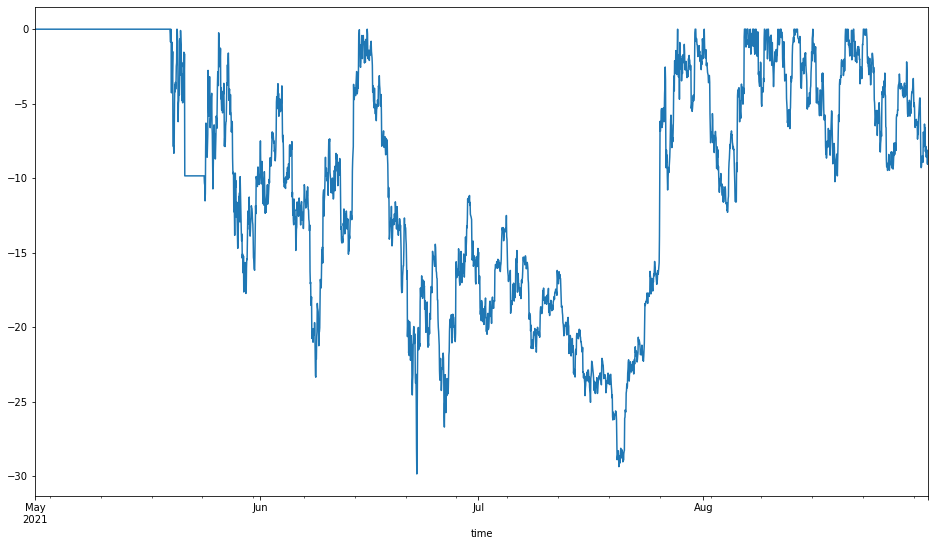

In [14]:
df.drawdown.plot()

## 6. Grid Search for k, h

(k, h) for a coin for return/residual CUSUM chart

In [33]:
def getScore(inputdf, coin='', feature='', method='montgomery', 
             kRange=[0.001, 0.002],
             hRange=[0.01, 0.02]):
#              kRange=np.arange(0.0006, 0.02, step=0.0003),
#              hRange=np.arange(0.001, 0.06, step=0.003)):
    if feature == "residualFeature":
        df = (inputdf
              .pipe(applyARIMA, coin)
              .pipe(calculateResidualFeature))
    elif feature == 'return':
        df = (inputdf
              .pipe(calculateReturn, coin))
    elif feature == 'regResidual':
        df = (inputdf
              .pipe(getRegResidual))
    else:
        print("Feature not found!")
    
    outputdf = pd.DataFrame(list(product(kRange, hRange)), columns=['k', 'h'])
    
    for k in kRange:
        for h in hRange:
            trades = createTradeSignal(df, k, h, feature=feature, method=method)
            kh = (outputdf.loc[:, 'k']==k) & (outputdf.loc[:, 'h']==h)
            outputdf.loc[kh, 'finalEquity'] = trades.equity[-1]
            
    return outputdf.sort_values(by='finalEquity', ascending=False)

In [34]:
df = getScore(traindf, coin='BTC', feature='return')

KeyError: 'BTC'

In [ ]:
df.head()

In [ ]:
plt.plot(df.loc[:,'k'], df.loc[:,'finalEquity'], label='k')
plt.plot(df.loc[:,'h'], df.loc[:,'finalEquity'], label='h')
plt.legend(loc='best')
plt.show()

## 7. Risk Adjusted for BioTech Stocks

Adjust biomedical company stock price by biotech indices 

### Price data exploration

- Data
    + Indices
        1. DJI Index: Dow Jones Industrial Average. 30 prominent companies listed on stock exchanges in the United States.
        2. SPX Index: Standard and Poor's 500. 500 large companies listed on stock exchanges in the United States.
        3. **NBI Index**: NASDAQ Biotechnology Index. 213 Biotechnology or the Pharmaceutical industry companies listed on NASDAQ.
        4. **SPSIBI Index**: S&P Biotechnology Select Industry Index. The biotechnology sub-industry portion of the S&P Total Markets Index (S&P TMI).
    + US Equities
        1. PFE US Equity: Pfizer Inc. American multinational pharmaceutical and biotechnology corporation headquartered on 42nd Street in Manhattan, New York City.
        2. **MRNA US Equity**: Moderna Inc.  Pharmaceutical and biotechnology company based in Cambridge, Massachusetts that focuses on RNA therapeutics, primarily mRNA vaccines.
        3. JNJ US Equity:Johnson & Johnson. Consumer Health, Pharmaceutical, and Medical Devices.
        
- Price visualization
    + Data looks clean

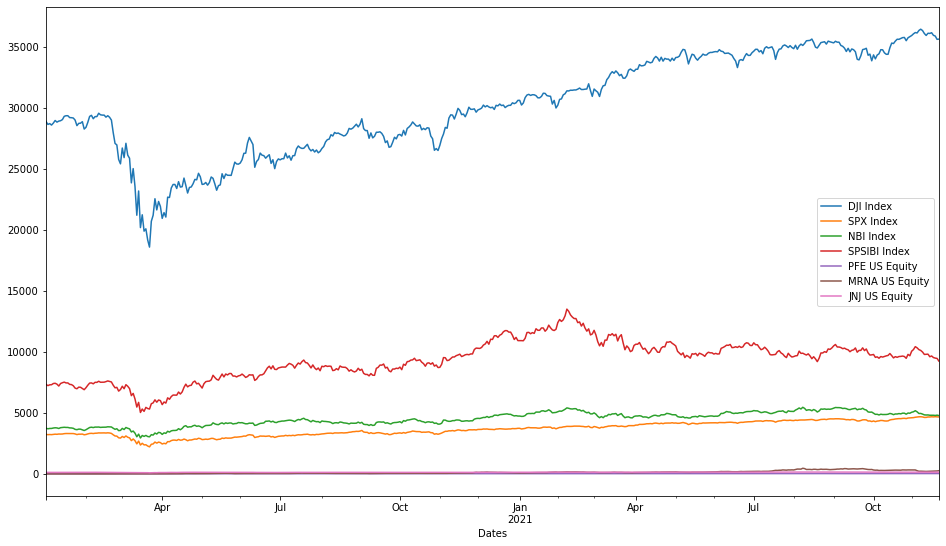

In [16]:
securities = pd.read_excel("../data/biostocks.xlsx", parse_dates=True, index_col="Dates")
securities.plot()
plt.show()

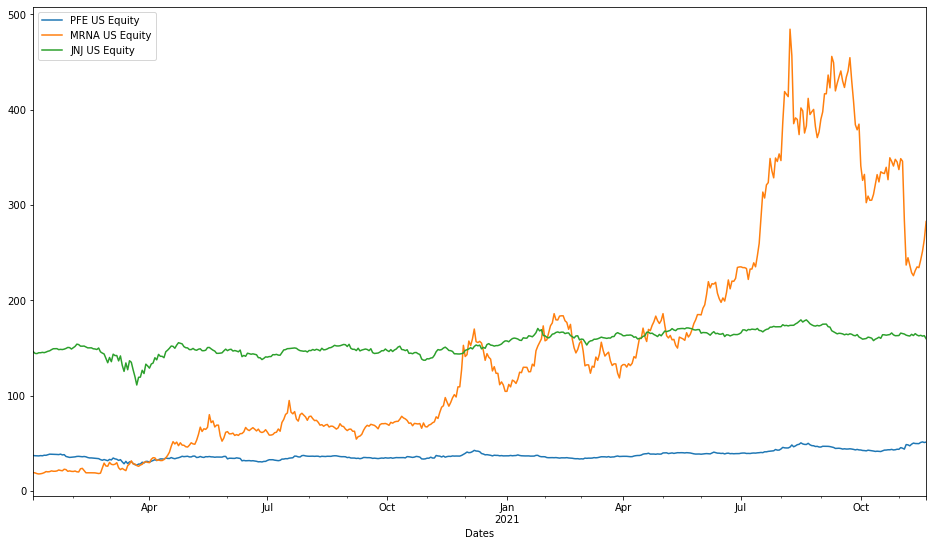

In [17]:
equityTicks = ["PFE US Equity", "MRNA US Equity", "JNJ US Equity"]
equities = securities.loc[:, equityTicks]
equities.plot()
plt.show()

In [36]:
def getRegResidual(df):
    df.loc[:, "price"] = df.loc[:, 'MRNA US Equity']
    X = df.loc[:, ['NBI Index', 'SPSIBI Index']]
    y = df.loc[:, 'MRNA US Equity']
    reg = LinearRegression().fit(X, y)
    prediction = reg.predict(X)
    df.loc[:, 'regResidual'] = y - prediction
    return df

In [37]:
traindf, testdf = trainTestSplit(securities)

In [23]:
traindf.head()

,DJI Index,SPX Index,NBI Index,SPSIBI Index,PFE US Equity,MRNA US Equity,JNJ US Equity
Dates,,,,,,,
2021-05-03,34113.23,4192.66,4862.98,10496.38,39.83,186.02,165.21
2021-05-04,34133.03,4164.66,4714.56,10059.70,39.95,173.59,167.77
2021-05-05,34230.34,4167.59,4676.82,9912.68,39.97,162.84,167.07
2021-05-06,34548.53,4201.62,4660.21,9769.91,39.19,160.50,167.74
2021-05-07,34777.76,4232.60,4702.29,9931.49,39.58,163.15,168.50


In [29]:
df = getRegResidual(traindf)
df.loc[df.loc[:,'regResidual']<0, :]

,DJI Index,SPX Index,NBI Index,SPSIBI Index,PFE US Equity,MRNA US Equity,JNJ US Equity,regResidual
Dates,,,,,,,,
2021-05-10,34742.82,4188.43,4616.05,9548.98,39.86,158.550,170.27,-3.879826
2021-05-13,34021.45,4112.50,4597.89,9499.26,40.10,149.870,169.96,-11.517585
2021-05-17,34327.79,4163.29,4715.93,9825.85,40.11,160.430,170.39,-7.317992
2021-05-18,34060.66,4127.83,4728.45,9886.85,40.05,159.530,170.45,-5.691076
2021-05-19,33896.04,4115.68,4679.14,9694.10,39.83,157.990,170.08,-11.414439
2021-05-20,34084.15,4159.12,4786.07,9906.09,40.12,165.970,171.07,-19.381504
2021-05-21,34207.84,4155.86,4753.39,9844.50,39.95,161.450,170.96,-18.639283
2021-05-24,34393.98,4197.05,4726.35,9766.96,39.81,164.170,170.55,-14.793411
2021-05-25,34312.46,4188.13,4697.19,9648.49,39.33,169.260,170.08,-12.722036


In [21]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.9010713429962383

In [40]:

reg = LinearRegression().fit(X, y)
prediction = reg.predict(X)
residual = (y - prediction)

array([0.0001, 0.0004, 0.0007, 0.001 , 0.0013, 0.0016, 0.0019, 0.0022,
       0.0025, 0.0028, 0.0031, 0.0034, 0.0037, 0.004 , 0.0043, 0.0046,
       0.0049, 0.0052, 0.0055, 0.0058])

In [41]:
np.arange(0.001, 0.06, step=0.003)

array([0.001, 0.004, 0.007, 0.01 , 0.013, 0.016, 0.019, 0.022, 0.025,
       0.028, 0.031, 0.034, 0.037, 0.04 , 0.043, 0.046, 0.049, 0.052,
       0.055, 0.058])

In [38]:
df = getScore(traindf, feature='regResidual')

In [39]:
df.to_csv("../output/scoreRA.csv")

In [40]:
df

,k,h,finalEquity
0,0.001,0.01,97.439279
1,0.001,0.02,97.439279
2,0.002,0.01,97.439279
3,0.002,0.02,97.439279


In [9]:
traindf, testdf = trainTestSplit(cryptos)

coin = "BTC"

df = (traindf
      .pipe(calculateReturn, coin)
      .pipe(createTradeSignal, k=0.005, h=0.005*10)) # , method="46"

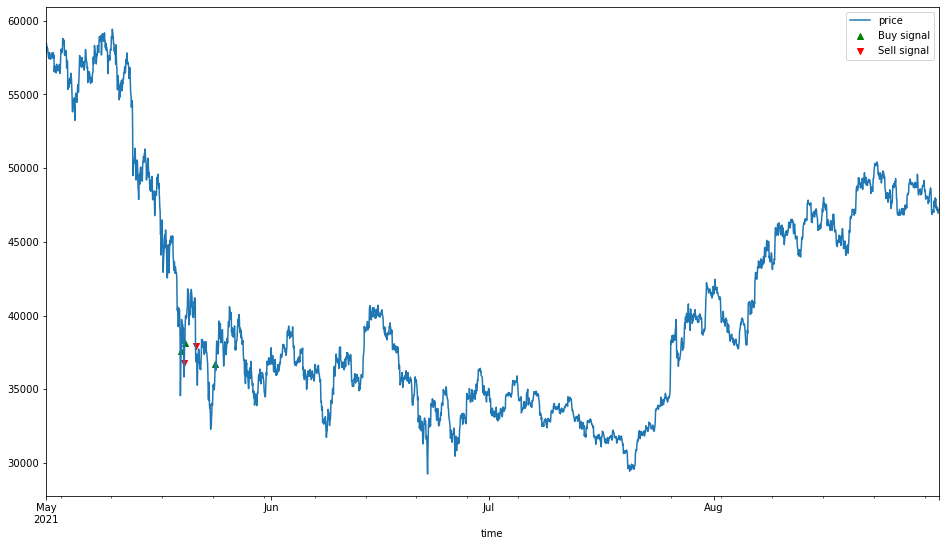

In [30]:
def plotPriceWithSignal(df):
    # optimze looking later
    df.loc[:, 'price'].plot()
    buy = df.loc[df['signal']==1, 'price']
    plt.scatter(buy.index, buy, c="g", marker="^", label="Buy signal")
    sell = df.loc[df['signal']==-1, 'price']
    plt.scatter(sell.index, sell, c="r", marker="v", label="Sell signal")
    plt.legend(loc='best')
    plt.show()
    
plotPriceWithSignal(df.head(10000))

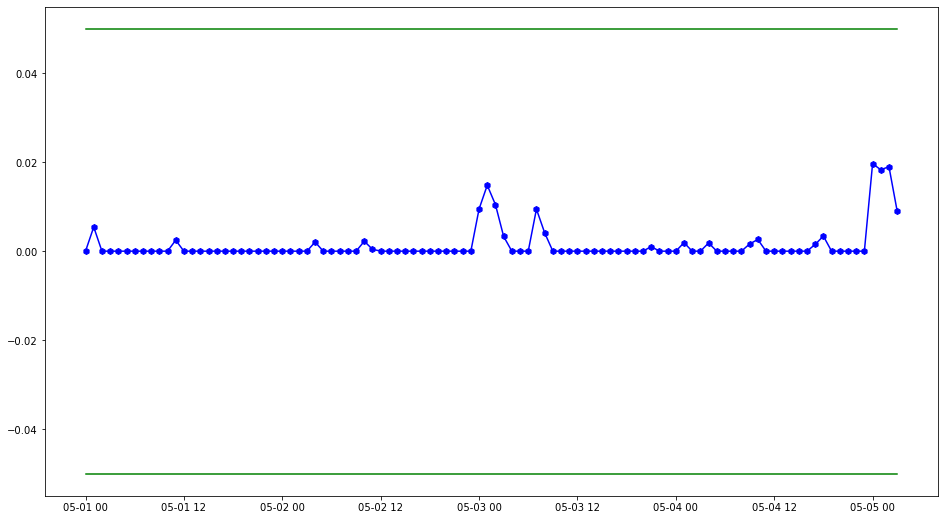

In [31]:
def plotCUSUM(df):
    plt.plot(df.index,df['cPlus'], color='b', marker='h', markersize=6)
    plt.plot(df.index,df['cMinus'], color='r', marker='h', markersize=6)
    plt.plot(df.index,np.array([h]*len(df.index)),color='g')
    plt.plot(df.index,np.array([-h]*len(df.index)),color='g')
    plt.show()
    

plotCUSUM(df.head(100))

In [32]:
### to delete
# calculate profit
buyPrice = df.loc[df['signal']==1, 'price']
sellPrice = df.loc[df['signal']==-1, 'price']
buyPriceEven = buyPrice[:len(sellPrice)]
np.sum((sellPrice.values-buyPriceEven.values)/buyPriceEven.values)

-0.027773356897836936